# Analysis Report

## Summary

**Feature**

* short comment to all analysis result
* summarize the todo for user

**Example**

* データの件数は十分です。
* ただ、精度はあまり出ていません


## Read Data

**Feature**

Try

* Read Data and Feature Type (Categorical/Numerical) setting.

Check

* Can not read data (file) -> unexpected format etc.
* Item Consistency -> number and string is mixtured

**Example**

* TODO: データのキャッシュ。毎回読み込むとAPIにかなり負荷がかかる
* TODO: 件数が多い場合の、データのダウンサンプリング(10000件程度に制限)

In [7]:
# Render our plots inline
%matplotlib inline

# Preparation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["font.family"] = "Yu Mincho"
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# Common Function

def get_figure_axis(column, length, figure_size=(15, 5)):
    fig = plt.figure(figsize=figure_size)
    fig_columns = column
    fig_rows = length // fig_columns + 1
    
    for i in range(length):
        ax = fig.add_subplot(fig_rows, fig_columns, i + 1)
        yield i, ax

# Load the data

FILE_NAME = "./data/titanic_train.csv"

df = pd.read_csv(FILE_NAME)
df.columns = [c.lower() for c in df.columns]

print("\"{}\"から{}件のデータの読み込みを行いました".format(FILE_NAME, len(df)))

df.head(5)
print(df.dtypes)

"./data/titanic_train.csv"から891件のデータの読み込みを行いました
passengerid      int64
survived         int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object


各列項目を、適切な形に変換します。項目情報は、以下を使用しています。

```
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
```

* TODO: 何らかの形で項目情報を取得・格納しておく必要あり(kintoneの場合はAPIから取得)

In [19]:
category_columns = ["pclass", "sex", "cabin", "embarked"]
number_columns = ["age", "sibsp", "parch", "fare"]
datetime_columns = []
target_column = "survived"

for c in category_columns:
    df[c] = df[c].astype("category")

for v in number_columns:
    df[v] = df[v].astype("float")

for d in datetime_columns:
    df[d] = pd.to_datetime(df[d])

print("各項目の種別は、以下のように設定されています")
print(df.dtypes)

各項目の種別は、以下のように設定されています
passengerid       int64
survived          int64
pclass         category
name             object
sex            category
age             float64
sibsp           float64
parch           float64
ticket           object
fare            float64
cabin          category
embarked       category
dtype: object


## Validate Data

**Feature**

* Check N/A Data
* Confirm value range

**Example**

* TODO: (最低限の)データ件数の判定について

In [20]:
if len(df) < 100:
    print("データの件数が少なすぎるようです。この状態では、正確な分析、また精度のあるモデルの構築は難しいです")

以下は、各項目について欠損データが含まれている割合を示したものです


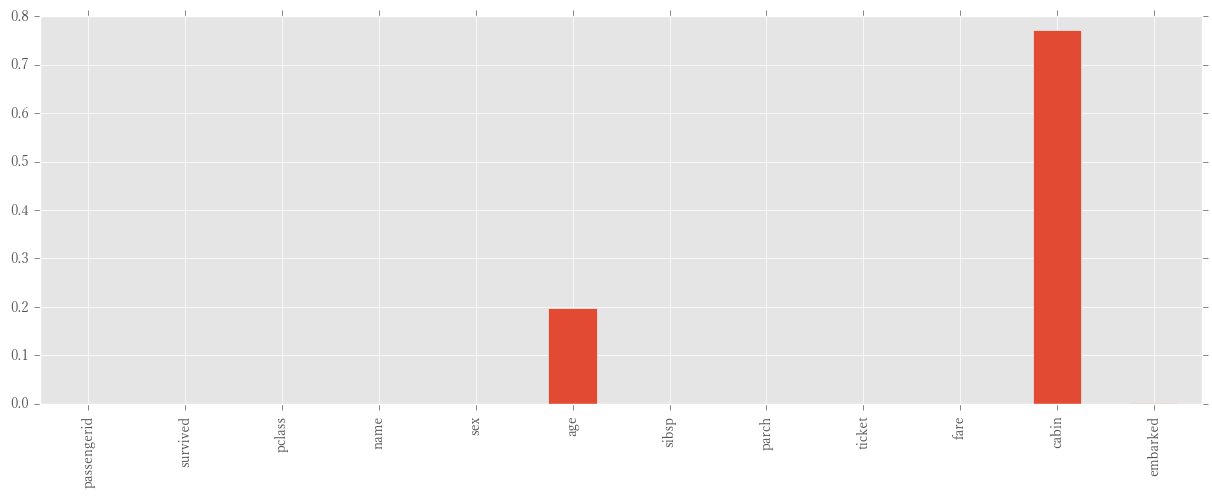

In [21]:
na_rates = 1 - df.count(axis=0) / len(df)
na_rates.plot.bar()
print("以下は、各項目について欠損データが含まれている割合を示したものです")

In [22]:
na_feature_candidates = na_rates.index[na_rates >= 0.2].tolist()
if len(na_feature_candidates):
    for nf in na_feature_candidates:
        print("{}は、欠損値が多い項目になっています({:.3}%)。この項目については除外して検討を進めます。".format(nf, na_rates[nf] * 100))
        if nf in df.columns:
            df = df.drop([nf], axis=1)
        for cs in [category_columns, number_columns, datetime_columns]:
            if nf in cs:
                cs.remove(nf)

cabinは、欠損値が多い項目になっています(77.1%)。この項目については除外して検討を進めます。


* TODO: 削除する欠損値の割合
* TODO: 欠損値の埋め方、埋められるケース(most frequentでうめるとか・・・)

## Statistics

項目の統計量をチェックします

* TODO: 統計量から判明した事実を基に(はずれ値が多いなど)、値の処理を行うか(sqrtをとるなど)


In [6]:
statistics = df.describe()
statistics

,passengerid,survived,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


数値項目について、分析を行います

age,sibsp,parch,fareは、ばらつきが少ない項目のようです。


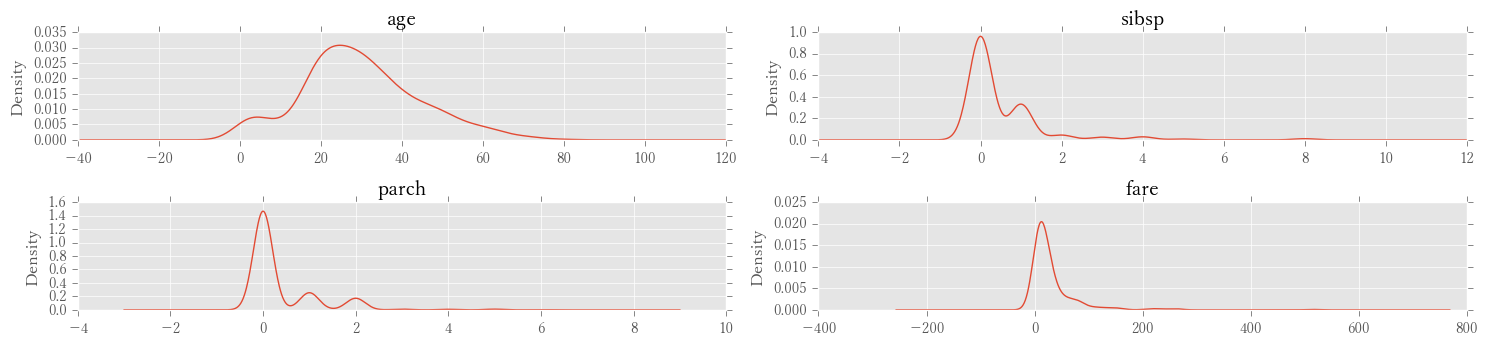

In [7]:
normalized_stds = (df[number_columns] / df[number_columns].max(axis=0)).dropna().std(axis=0)

gathered = normalized_stds.index[normalized_stds <= 0.5]
scattered = normalized_stds.index[normalized_stds >= 2]

if len(gathered) > 0:
    print("{}は、ばらつきが少ない項目のようです。".format(",".join(gathered)))
if len(scattered) > 0:
    print("{}は、ばらつきが大きい項目のようです。".format(",".join(scattered)))

for i, ax in get_figure_axis(2, len(normalized_stds.index)):
    n = normalized_stds.index[i]
    df[n].plot.kde(ax=ax)
    plt.title(n)
plt.tight_layout()

カテゴリ項目について、分析を行います

sex,embarkedは、ばらつきが少ない項目のようです。


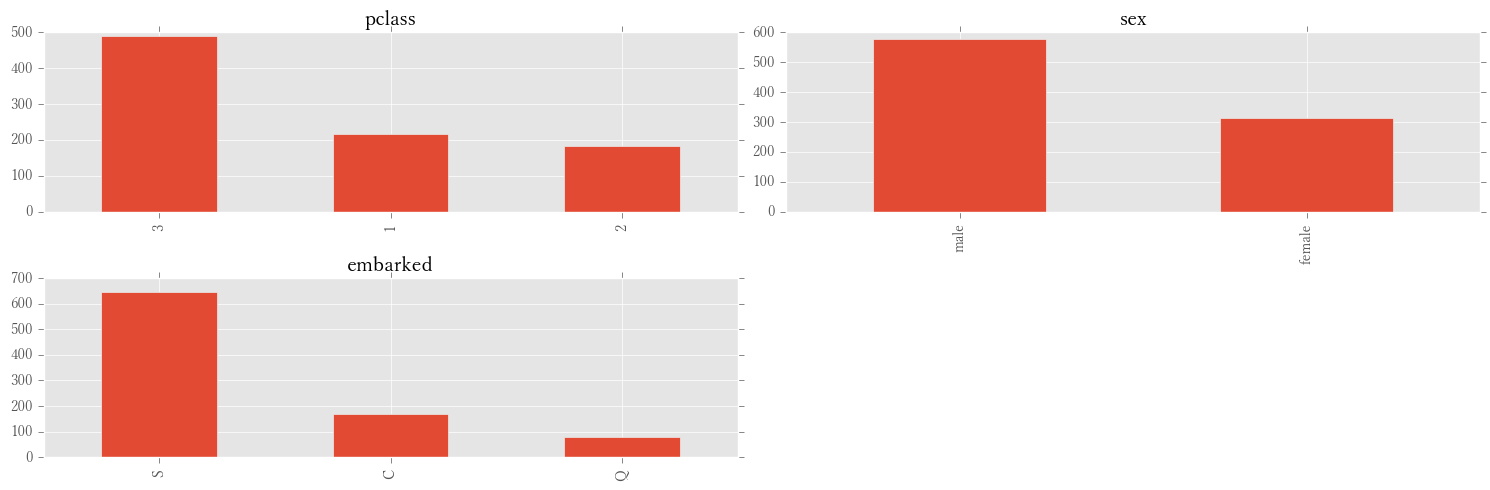

In [8]:
gathered = []
scattered = []

for i, ax in get_figure_axis(2, len(category_columns)):
    c = category_columns[i]
    vc = df[c].value_counts(sort=True, ascending=False)
    if vc.iloc[0] / vc.sum() > 0.6:
        gathered.append(c)
    elif vc.iloc[0] / vc.sum() <= 0.2:
        scattered.append(c)
    
    vc.plot.bar(ax=ax)
    plt.title(c)
plt.tight_layout()

if len(gathered) > 0:
    print("{}は、ばらつきが少ない項目のようです。".format(",".join(gathered)))
if len(scattered) > 0:
    print("{}は、ばらつきが大きい項目のようです。".format(",".join(scattered)))    

## Visualize

予測に有効な特徴を探すため、各項目(=特徴量)が、予測対象にどれだけ効いているかを確認します。  
これには、図を利用した分析が効果的です。

|            | 値項目        | カテゴリ項目 |
|:-----------|:--------------|:------------:|
| 値の予測   | Scatter Plots | Density Plots|
| カテゴリの予測 | Box Plots     | Mosaic Plots |


### Scatter Plots

(必要に応じ、出力される値は異なる。今回は予測がカテゴリなので本来値の予測の図は必要ないが、コードサンプルを残すために表示する)


age,sibsp,parch,fareの中で、survivedと相関関係にある項目はないようです


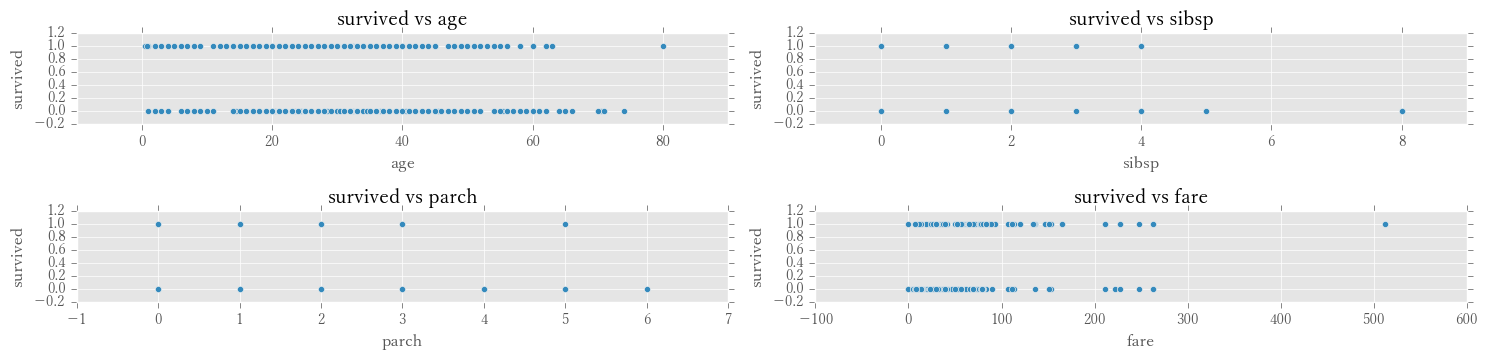

In [9]:
def plot_scatter(df, number, target, value_function=None, ax=None):
    resource = df[[number, target]].dropna()
    if value_function:
        resource = resource.apply(lambda x: value_function(x))
    resource.plot(kind="scatter", x=number, y=target, ax=ax);
    

high_corr = []
for i, ax in get_figure_axis(2, len(number_columns)):
    n = number_columns[i]
    plot_scatter(df, n, target_column, ax=ax)
    plt.title("{} vs {}".format(target_column, n))
    
    corr = df[[number_columns[i], target_column]].corr()[n][target_column]
    if corr >= 0.5:
        high_corr.append(corr)
    
plt.tight_layout()
if len(high_corr) > 0:
    print("{}は、{}と相関が高い項目です".format(",".join(high_corr), target_column))
else:
    print("{}の中で、{}と相関関係にある項目はないようです".format(",".join(number_columns), target_column))


* TODO: 相関関係を判定する値の敷居値

### Density Plot

pclass,sex,embarkedの中で、survivedを識別するのに役立ちそうな項目はないようです


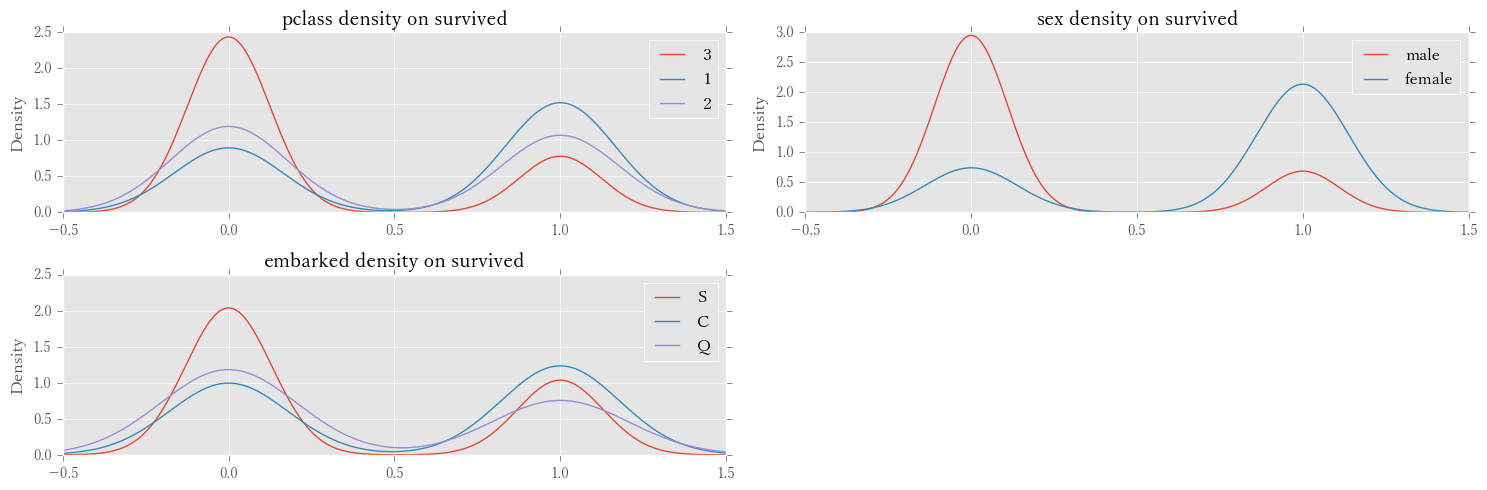

In [23]:
def plot_density(df, category, target, top_n=10, value_function=None, ax=None):
    from scipy.stats import gaussian_kde
    _df = df[[category, target]]
    
    tops = _df[category].value_counts(sort=True, ascending=False)[:top_n].index.tolist()
    top_values = _df[_df[category].isin(tops)]

    samples = []
    for i, t_c in enumerate(tops):
        v = top_values[top_values[category] == t_c].rename(columns={target: t_c})
        if value_function:
            v[t_c] = v[t_c].apply(lambda x: value_function(x))
        try:
            v.plot.kde(ax=ax)
            gkde = gaussian_kde(v[t_c].dropna().values)
            indixies = np.linspace(v[t_c].min(), v[t_c].max(), 1000)
            sv = gkde.evaluate(indixies)
            samples.append(sv)
                
        except Exception as ex:
            print("Exception occurred when ploting {}. {}".format(category, ex))
    plt.title("{} density on {}".format(category, target))
    return samples


high_var = []
for i, ax in get_figure_axis(2, len(category_columns)):
    c = category_columns[i]
    samples = plot_density(df, c, target_column, ax=ax)
    f_val, p_val = stats.f_oneway(*samples)
    if p_val < 0.05:
        high_var.append(c)

plt.tight_layout()

if len(high_var) > 0:
    print("{}は、{}の値を識別するのに役立ちそうです".format(",".join(high_var), target_column))
else:
    print("{}の中で、{}を識別するのに役立ちそうな項目はないようです".format(",".join(category_columns), target_column))


* TODO: p値の敷居値

### BoxPlots

age,parch,fareは、survivedの値を識別するのに役立ちそうです


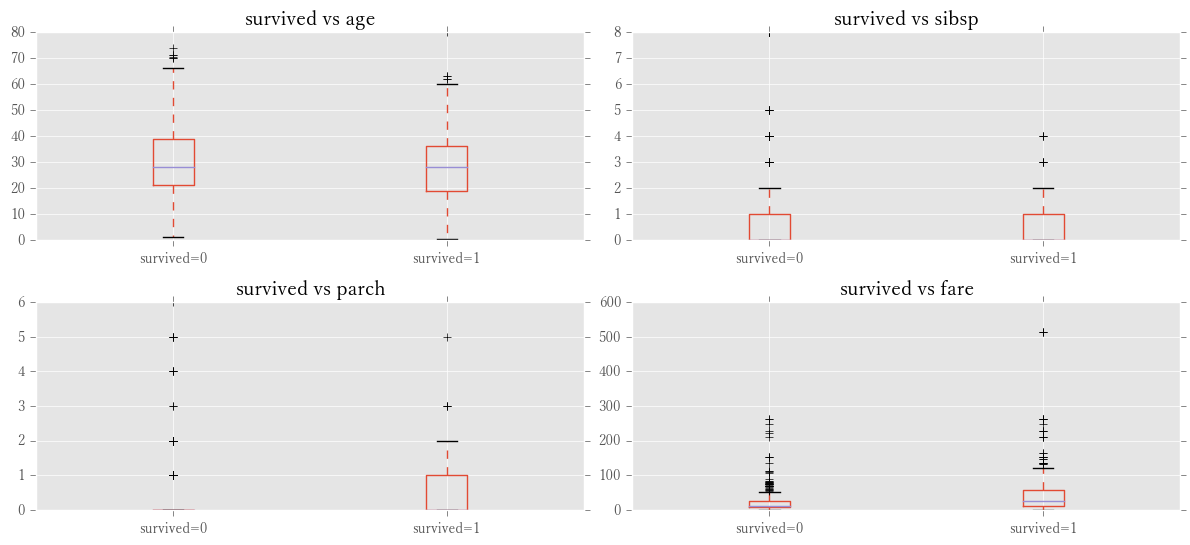

In [24]:
def plot_box(df, number, target, value_function=None, ax=None):
    _df = df[[number, target]].dropna()
    if value_function:
        _df = _df.apply(lambda x: value_function(x))
    classes = _df[target].value_counts().index.tolist()
    _data = {}
    for c in classes:
        s = _df[number][_df[target] == c]
        _data["{}={}".format(target, c)] = s
    pd.DataFrame(_data).plot(kind="box", ax=ax)
    return _data

high_var = []
for i, ax in get_figure_axis(2, len(number_columns), figure_size=(12, 8)):
    n = number_columns[i]
    data = plot_box(df, n, target_column, ax=ax)
    plt.title("{} vs {}".format(target_column, n))

    f_val, p_val = stats.f_oneway(*list(data.values()))
    if p_val < 0.05:
        high_var.append(n)

plt.tight_layout()

if len(high_var) > 0:
    print("{}は、{}の値を識別するのに役立ちそうです".format(",".join(high_var), target_column))
else:
    print("{}の中で、{}を識別するのに役立ちそうな項目はないようです".format(",".join(category_columns), target_column))


### Mosaic Plot

pclass,sex,embarkedは、survivedの値を識別するのに役立つかもれいません


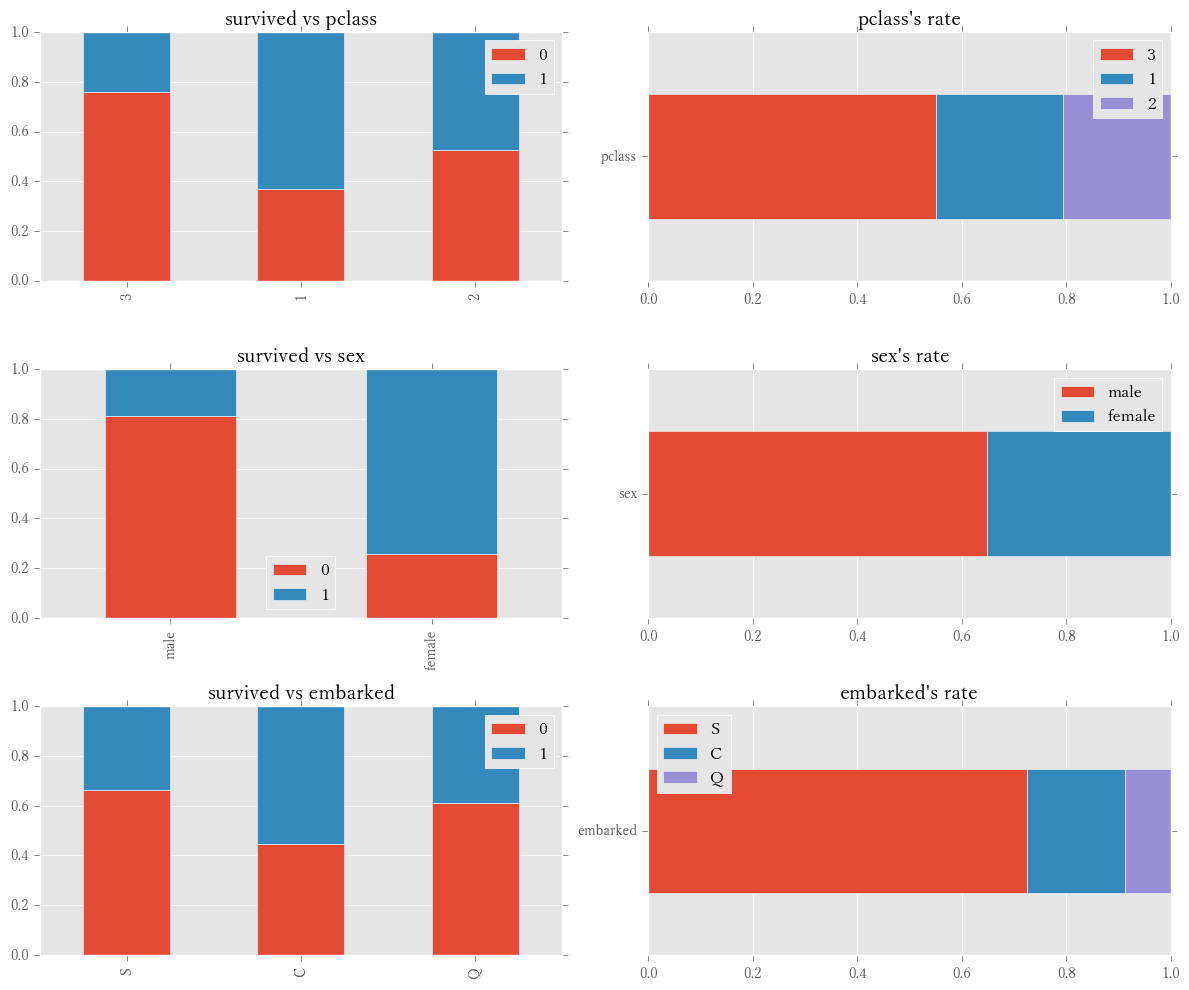

In [25]:
def plot_mosaic(df, category, target, top_n=10, ax=None):
    _df = df[[category, target]].dropna()
    
    top_counts = _df[category].value_counts(sort=True, ascending=False)[:top_n]
    tops = top_counts.index.tolist()
    target_counts = df[target].value_counts()
    targets = target_counts.index.tolist()
    
    _data = {}
    for t in targets:
        vs = []
        for c in tops:
            total = len(_df[_df[category] == c])
            if total < 1:
                continue
            v = len(_df[(_df[category] == c) & (_df[target] == t)]) / total
            vs.append(v)
        _data[t] = pd.Series(vs, index=tops)
    
    pd.DataFrame(_data).plot(kind="bar", ax=ax, stacked=True)
    return _data, top_counts / _df[category].value_counts().sum()

fig = plt.figure(figsize=(12, 10))
fig_columns = 2
fig_rows = len(category_columns)

candidates = []

for i in range(fig_rows):
    base = i * 2
    ax1 = fig.add_subplot(fig_rows, fig_columns, base + 1)
    c = category_columns[i]
    data, top_rates = plot_mosaic(df, c, target_column, ax=ax1)
    plt.title("{} vs {}".format(target_column, c))
    
    ax2 = fig.add_subplot(fig_rows, fig_columns, base + 2)
    top_rates.to_frame().transpose().plot.barh(ax=ax2, stacked=True)
    plt.title("{}'s rate".format(c))
    
    for k in data:
        diff = max(data[k]) - min(data[k])
        if diff < 0.6 and c not in candidates:
            candidates.append(c)
    
plt.tight_layout()

if len(candidates) > 0:
    print("{}は、{}の値を識別するのに役立つかもれいません".format(",".join(candidates), target_column))
else:
    print("{}の中で、{}を識別するのに役立ちそうな項目はなさそうです".format(",".join(candidates), target_column))


## Make Model

では、特徴量を使用しモデルを作成していきます。

### Make Feature Columns

カテゴリ項目や文字列の項目はそのままでは使用できないため、これを変換します。


In [34]:
features = []
top_n = 100
others_dummy = "OTHERS"

for c in df.columns:
    if c in number_columns + [target_column]:
        features.append(df[c])  # todo: think about value scaling
    elif c in category_columns:
        tops = df[c].value_counts(sort=True, ascending=False)[:top_n].index.tolist()
        converted = df[c].apply(lambda x: x if x in tops else others_dummy)
        f = pd.get_dummies(converted, prefix=c)
        features.append(f)
    elif c in datetime_columns:
        features.append(df[c])  # todo: think about datetime handling

df_f = pd.concat(features, axis=1)
df_f.head(5)

,survived,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,0,0,0,1,0,1,22.0,1.0,0.0,7.2500,0,0,1
1,1,1,0,0,1,0,38.0,1.0,0.0,71.2833,1,0,0
2,1,0,0,1,1,0,26.0,0.0,0.0,7.9250,0,0,1
3,1,1,0,0,1,0,35.0,1.0,0.0,53.1000,0,0,1
4,0,0,0,1,0,1,35.0,0.0,0.0,8.0500,0,0,1


### Feature Selection

予測や分類にとって最適なモデル、特徴量を探索します

* TODO: 特徴量選択に使用するモデル


In [99]:
from sklearn.model_selection import train_test_split


# split dataest
datasets = []
targets = []
for d in train_test_split(df_f.dropna(), test_size=0.2):
    targets.append(d[target_column])
    datasets.append(d.drop(target_column, axis=1))

df_train, df_test = datasets
df_train_t, df_test_t = targets

Optimal number of features : 4 (accuracy=0.7758519334986681)


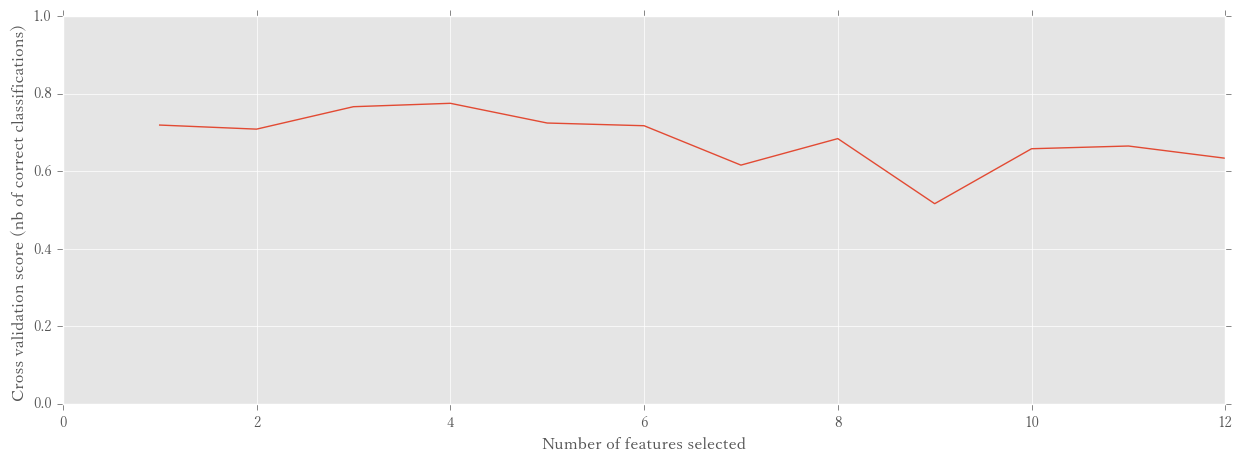

Optimal number of features : 7 (accuracy=0.8091577110315055)


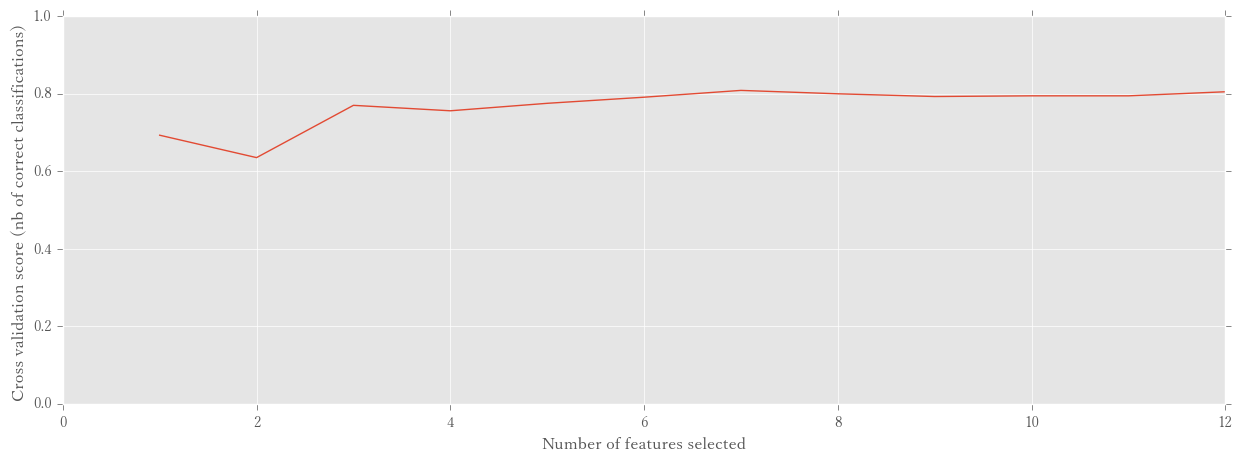

In [122]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV


# feature validator
clf = SGDClassifier(alpha=0.001)
tree = RandomForestClassifier(n_estimators=10)
models = [clf, tree]  # some models
cv_count = 3
best_rfecv = None

for m in models:
    rfecv = RFECV(estimator=m, step=1, cv=cv_count, scoring="accuracy")
    rfecv.fit(df_traindf, df_train_t)
    
    if best_rfecv is None or max(rfecv.grid_scores_) > max(best_rfecv.grid_scores_):
        best_rfecv = rfecv
    
    print("Optimal number of features : {} (accuracy={})".format(rfecv.n_features_, max(rfecv.grid_scores_)))

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.ylim(0, 1)
    plt.show()

In [141]:
valid_features = df_train.columns[best_rfecv.get_support()].tolist()
print("{} がモデルの構築に有効な特徴量のようです。これらを使用し、モデルのチューニングを行います".format(",".join(valid_feature)))

pclass_1,pclass_3,sex_female,sex_male,age,parch,fare がモデルの構築に有効な特徴量のようです。これらを使用し、モデルのチューニングを行います


### Build the Model

得られた特徴量を使用し、モデルの作成を行います。


In [171]:
from sklearn.model_selection import GridSearchCV


df_selected = df_train
df_selected_t = df_test

for ex in [c for c in df_train.columns if c not in valid_features]:
    df_selected = df_selected.drop(ex, axis=1)
    df_selected_t = df_selected_t.drop(ex, axis=1)
    
tree = RandomForestClassifier(n_estimators=10)
tree_params = { 
    "n_estimators": [10, 20, 30],
    "max_features": ["auto", "sqrt", "log2"]
}
model_and_params = [(tree, tree_params)]  # todo prepare multiple models

best_gv = None
score = -1

for m, p in model_and_params:
    gv = GridSearchCV(m, p)
    gv.fit(df_selected, df_train_t)
    
    if score < gv.best_score_:
        best_gv = gv
        score = gv.best_score_

print("モデルの精度は{:.3}%です".format(score * 100))
if score >= 0.7:
    print("十分に使える精度といえます！")
else:
    print("もう少し改善が必要なようです")
    

モデルの精度は80.7%です
十分に使える精度といえます！


<module 'matplotlib.pyplot' from 'C:\\Users\\smap6\\Documents\\envs\\Miniconda3_32\\envs\\ml_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

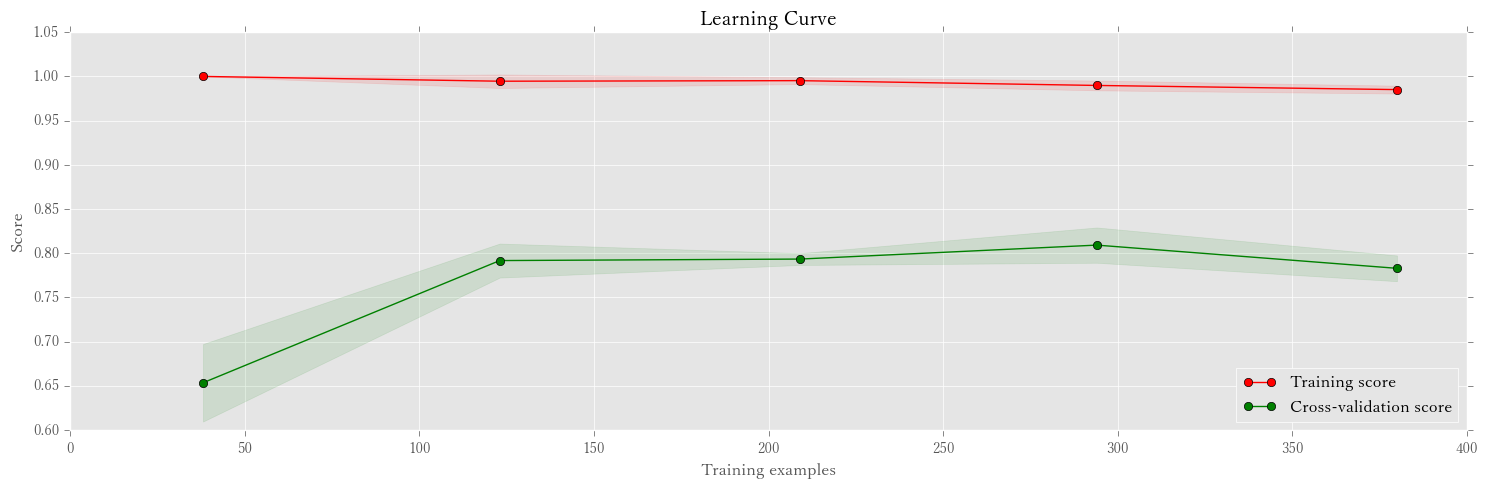

In [144]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y, title="Learning Curve", ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid()
    plt.tight_layout()
    return plt


best_practice = best_gv.best_estimator_.__class__(**best_gv.best_params_)
plot_learning_curve(best_practice, df_train, df_train_t)

* TODO: overfitting/underfittingの判断
* データの追加要否(精度の上がり具合から判断)

### Evaluate the Model

In [152]:
from sklearn.metrics import classification_report


prediction = best_gv.best_estimator_.predict(df_selected_t)
target_names = df_test_t.value_counts().index.tolist()

print(classification_report(df_test_t, prediction, target_names=[str(t) for t in target_names]))

             precision    recall  f1-score   support

          0       0.85      0.82      0.84        85
          1       0.75      0.79      0.77        58

avg / total       0.81      0.81      0.81       143



* TODO: 見せかけの高精度の見破り

0


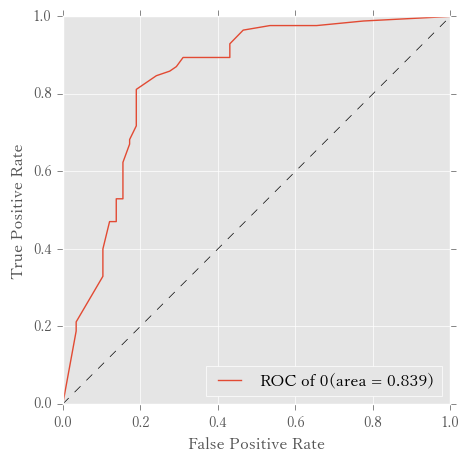

In [168]:
from sklearn.metrics import roc_curve, auc


probs = best_gv.best_estimator_.predict_proba(df_selected_t)

plt.figure(figsize=(5, 5))

for t in range(probs.shape[1] - 1):
    print(t)
    y = df_test_t.apply(lambda x: 1 if x == t else 0)
    fpr, tpr, thresholds = roc_curve(y, probs[:, t])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC of {}(area = {:.3})".format(t, roc_auc))

plt.plot([0, 1], [0, 1], linestyle="--", lw=0.5, color="k")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)

* TODO: モデルの評価
